### This notebook loads surface information (in this case just saved in text files) which describes the elevation of the basin in Reno Nevada and the the surface (sampled from a DEM). These are saved to the coordinates files so that they may be used later to set interpolation boundaries.

In [1]:
import numpy as np
import json
import points2Rfile
from points2Rfile import grid
import dask.array as da #so I can easily save to hdf5, do not actually do any parallel computing in this module
import utm #to convert input coords to utm which is easier to preform distance calculations with

In [2]:
#load the raw data
dem_raw = np.genfromtxt("AL_DEM.txt",delimiter=',')
basin_raw = np.genfromtxt("alKrigged100M.txt",delimiter=',')
topSurface = 3
surfaceUnit = 1
basinUnit = 2
elevationToAdd = 0 #added to the surface unit so that it does not overlap!
modelResolution = 100.00
UTMZONEN=11
UTMZONELETTER='N'

In [3]:
mpropsINI = "mprops.ini"
fname = inputGridFile = "renoRemi100m.hdf5"
chunk_size=10000
#generate an empty grid file with appropriate dimensions, chunks and spacing
try:
    grid.genGridFile(fname=fname,iniFname="100m.ini")
except RuntimeError:
    print("grid file already exsists! Using existing gridFile")
except TypeError:
    print("grid file already exsists! Using existing gridFile")

In [4]:
#load the grid file
gridFile = grid.grid(fname=inputGridFile)
DX,DY = gridFile.mdata["DX"],gridFile.mdata["DY"]
NX,NY = gridFile.mdata["NX"],gridFile.mdata["NY"]
if(gridFile.mdata["DZ"] != modelResolution):
    print("warning: there is an mismatch between the resolution declared in the .ini construction file and in this model!")

In [5]:
#reformat this input data into lat,lon,depth and (if applicable) unit
#note that in the arcgis output row 1 is the row id, 2 is the longitude 3 is the lattitude and 4 is the elvation
dem = np.zeros(shape=(len(dem_raw[:,2]),4))
basin = np.zeros(shape=(len(basin_raw[:,2]),4))
#now assign properties to each
dem[:,0],dem[:,1],dem[:,2] = dem_raw[:,3],dem_raw[:,2],dem_raw[:,4]
basin[:,0],basin[:,1],basin[:,2] = basin_raw[:,3],basin_raw[:,2],basin_raw[:,4]
#assign surface to the dem
dem[:,3] = surfaceUnit
#assign the basin unit basin 
basin[:,3] = basinUnit
basin[:,2] = basin[:,2]


In [6]:
#datum
xMin,yMin = utm.from_latlon(latitude=gridFile.mdata["LAT0"],longitude=gridFile.mdata["LON0"],force_zone_letter=UTMZONELETTER,force_zone_number=UTMZONEN)[:2]
#convert to cartesian
coordinates = utm.from_latlon(latitude=dem[:,0],longitude=dem[:,1],force_zone_letter=UTMZONELETTER,force_zone_number=UTMZONEN)
dem[:,0],dem[:,1] = coordinates[0],coordinates[1]
#apply horrizontal datums
dem[:,0] = dem[:,0]-xMin
dem[:,1] = dem[:,1]-yMin
print(min(dem[:,0]))
print(max(dem[:,0]))

#do the same for the basin
#convert to cartesian
coordinates = utm.from_latlon(latitude=basin[:,0],longitude=basin[:,1],force_zone_letter=UTMZONELETTER,force_zone_number=UTMZONEN)
basin[:,0],basin[:,1] = coordinates[0],coordinates[1]
#apply datum
basin[:,0] = basin[:,0]-xMin
basin[:,1] = basin[:,1]-yMin
print(min(basin[:,0]))
print(max(basin[:,0]))

0.0
33686.87118097962
-54.81526957888855
33713.26817694804


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
(x,y) = np.meshgrid(np.linspace(0,DY*NY,NY),np.linspace(0,DX*NX,NX),indexing='xy')

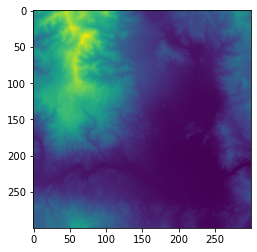

In [8]:
#fix surface
from scipy.interpolate import griddata 
units = griddata((dem[:,0],dem[:,1]),(dem[:,3]),(x,y),method="nearest",rescale=False)
z = griddata((dem[:,0],dem[:,1]),(dem[:,2]),(x,y),method="nearest",rescale=False)
imgplot = plt.imshow(z)
dem = np.zeros(shape=(x.flatten().shape[0],4))
dem[:,2] = z.flatten()
dem[:,3] = units.flatten()
dem[:,0],dem[:,1] = x.flatten(),y.flatten()


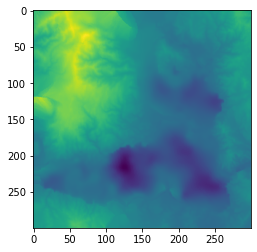

In [9]:
#fix basin
units = griddata((basin[:,0],basin[:,1]),(basin[:,3]),(x,y),method="nearest",rescale=False)
z = griddata((basin[:,0],basin[:,1]),(basin[:,2]),(x,y),method="nearest",rescale=False)
basin = np.zeros(shape=(x.flatten().shape[0],4))
basin[:,3] = units.flatten()
basin[:,0],basin[:,1] = x.flatten(),y.flatten()
basin[:,2] = z.flatten()
imgplot = plt.imshow(z)

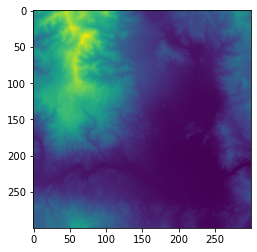

In [10]:
#save the topography
gridFile.assignDEMToGrid(dem=dem,cartesian=True)
gridFile = grid.grid(fname=inputGridFile)
a = griddata((dem[:,0],dem[:,1]),(dem[:,2]),(x,y),method='nearest',rescale=False)
test = gridFile.topo.compute()
imgplot = plt.imshow(test)
basinTopo = test

In [11]:
#verify that the surfaces do not overlap
overlaps = np.where(basin[:,2] >= dem[:,2])[0]
#subtract off 10 m (i.e assign the basin to equal 10 m)
basin[:,2][overlaps] = dem[:,2][overlaps]-1.0


In [12]:
#convert input points
#I am subtracting because I am going from the surface DOWN
#lower the whole basin by 50

basin[:,2]=basin[:,2]-modelResolution
basin2 = np.copy(basin)
basin2[:,3] = surfaceUnit
basin2[:,2] = basin2[:,2] + modelResolution
basinFloor = np.copy(basin)
basinFloor[:,2] = basinFloor[:,2]-2*modelResolution

dem2 = np.copy(dem)
dem2[:,3] = topSurface
dem2[:,2]=dem[:,2]-1.0

inputPoints = np.vstack([basin,basin2,dem2])#stack for ease of use
#dump all invalid points
#inputPoints = inputPoints[~np.isnan(inputPoints).any(axis=1)]
#create empty vectory to hold vp vs etc. 
vp,vs,p,qp,qs = np.zeros(inputPoints.shape[0],dtype=np.float32),np.zeros(inputPoints.shape[0],dtype=np.float32),np.zeros(inputPoints.shape[0],dtype=np.float32),np.zeros(inputPoints.shape[0],dtype=np.float32),np.zeros(inputPoints.shape[0],dtype=np.float32)

In [13]:
#load mprops ini file
with open(mpropsINI,'r') as fileObject:
    mpropsINI = [line.strip() for line in fileObject if("#" not in line.strip())]
mpropsINI = json.loads(r''.join(mpropsINI))

In [14]:
#use information in mprops to assign mprops to data inputs
for i in mpropsINI["UNITS"].keys():
    indexes = np.where(inputPoints[:,3] == np.float32(i))
    #assign
    vp[indexes] = mpropsINI["UNITS"][i]["VP"]
    vs[indexes] = mpropsINI["UNITS"][i]["VS"]
    p[indexes] = mpropsINI["UNITS"][i]["P"]
    qp[indexes] = mpropsINI["UNITS"][i]["QP"]
    qs[indexes] = mpropsINI["UNITS"][i]["QS"]

In [15]:
"""
Scale points from the datum
"""
inputPoints[:,2] = 8000 - (inputPoints[:,2] + gridFile.mdata["datum"])

In [16]:
### This is designed to add an points object to the grid for each data set mentioned above
surfaces = points2Rfile.grid.points(gridFile,"DEMAndBasin","basin bottom and DEM used in this model","s",inputPoints[:,0],inputPoints[:,1],inputPoints[:,2],inputPoints[:,3]
                                   ,vp,vs,p,qp,qs,overwrite=True)

### now save the basin elevation and the DEM as surfaces to the geometeries part of the rfile

In [17]:
basinElevation = points2Rfile.grid.surfaces(gridObj=gridFile,dataSet="BasinElevation",comment="The basin elevation surface",dataType="S",surface=z,overwrite=True)
###Do the same for the DEM
modelSurface = points2Rfile.grid.surfaces(gridObj=gridFile,dataSet="DEMElevation",comment="The eelvation of the DEM",dataType="S",surface=basinTopo,overwrite=True)


trying to save data set!
trying to save data set!


In [ ]:
#make sure that the the hdf5 container is close 
gridFile.data.close()